Loading Dependencies:

In [1]:
import pandas as pd
import numpy as np
import os
import cv2 as cv 
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory

Check if GPU is available:

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13748795770980958273
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5732564992
locality {
  bus_id: 1
  links {
  }
}
incarnation: 940617186012490846
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:05:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


#  Importing the data
## Trying out another method

In [3]:
# All the folders in the training directory
categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
train_dir = "./data/Training/"
test_dir = "./data/Testing/"

# Initialize image & batch size
IMG_SIZE = 300
batch_size = 128

In [4]:
# Augment training data
train_datagen = ImageDataGenerator(
      rescale=1./255)

# No augmentation on the test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate with flow from directory
train_generator = train_datagen.flow_from_directory(
        train_dir,
        color_mode='grayscale',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='sparse')

# Generate with flow from directory
test_generator = test_datagen.flow_from_directory(
        test_dir,
        color_mode='grayscale',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        class_mode='sparse')


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [5]:
keys = train_generator.class_indices
keys

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [6]:
def get_key(val):
    for key, value in keys.items():
        if val == value:
            return key
 
    return "key doesn't exist"


get_key(0)

'glioma_tumor'

Showing some of the augmented images:

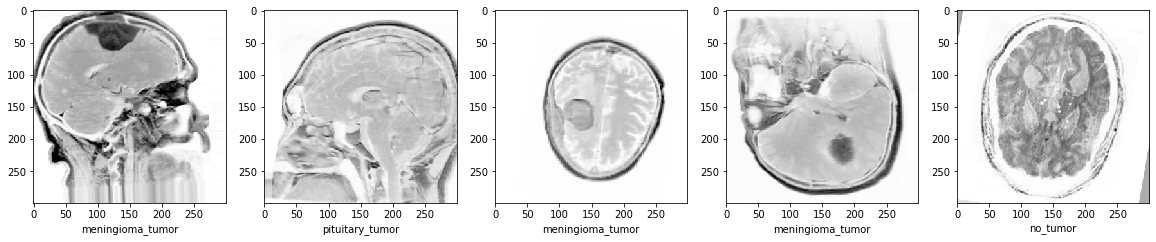

In [7]:
fig, axs = plt.subplots(1,5, figsize=(20, 10), facecolor='w', edgecolor='k')
for i in range(5):
    img, label = train_generator.next()
    axs[i].imshow(img[0], cmap="Greys", interpolation='nearest')
    axs[i].set_xlabel(get_key(label[0]))

plt.show()


Showing some unaugmented pictures:

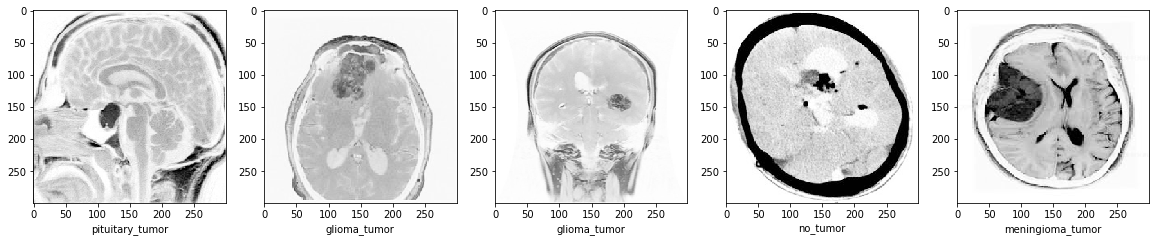

In [8]:
fig, axs = plt.subplots(1,5, figsize=(20, 10), facecolor='w', edgecolor='k')
for i in range(5):
    img, label = test_generator.next()
    axs[i].imshow(img[0], cmap="Greys", interpolation='nearest')
    axs[i].set_xlabel(get_key(label[0]))

plt.show()


Shuffle the data since otherwise the neural network doesn't learn very well:

Create the training/testing Y & X:

As can be seen here it can be quite hard to distuingish between tumors for an untrained eye, while some others can be more easily spotted. Seems like a good case for machine learning:

# Building the Neural Network

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size = (5,5), filters = 32, activation ="relu", padding = "same"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(kernel_size = (3,3), filters = 64, activation ="relu", padding = "same"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(kernel_size = (3,3), filters = 128, activation ="relu", padding = "same"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(kernel_size = (4,4), filters = 256, activation ="relu", padding = "same"),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dropout(rate = 0.5),
    tf.keras.layers.Dense(4, activation = "softmax")
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=test_generator.n//test_generator.batch_size
with tf.device('/gpu:0'):
    history = model.fit_generator(generator = train_generator, steps_per_epoch = STEP_SIZE_TRAIN, validation_data=test_generator, validation_steps = STEP_SIZE_VALID, epochs = 20) 

C:\Users\felix\AppData\Local\Temp\ipykernel_16596\3388983299.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_generator, steps_per_epoch = STEP_SIZE_TRAIN, validation_data=test_generator, validation_steps = STEP_SIZE_VALID, epochs = 20)


Epoch 1/20
22/22 [==============================] - 23s 712ms/step - loss: 1.3655 - accuracy: 0.3669 - val_loss: 1.4258 - val_accuracy: 0.1979
Epoch 2/20
22/22 [==============================] - 12s 546ms/step - loss: 1.3345 - accuracy: 0.4132 - val_loss: 1.4794 - val_accuracy: 0.1979
Epoch 3/20
22/22 [==============================] - 12s 546ms/step - loss: 1.2944 - accuracy: 0.4416 - val_loss: 1.5310 - val_accuracy: 0.2161
Epoch 4/20
22/22 [==============================] - 12s 550ms/step - loss: 1.2629 - accuracy: 0.4274 - val_loss: 1.7021 - val_accuracy: 0.2318
Epoch 5/20
22/22 [==============================] - 12s 542ms/step - loss: 1.2417 - accuracy: 0.4409 - val_loss: 1.7686 - val_accuracy: 0.2344
Epoch 6/20
22/22 [==============================] - 12s 546ms/step - loss: 1.2338 - accuracy: 0.4406 - val_loss: 1.8327 - val_accuracy: 0.2422
Epoch 7/20
22/22 [==============================] - 12s 550ms/step - loss: 1.2220 - accuracy: 0.4519 - val_loss: 1.7699 - val_accuracy: 0.2474

Test predictions:

In [ ]:
# Getting the probabilities
y_pred = model.predict(X_test)

# Getting the classes
y_pred_classes = np.argmax(y_pred,axis=1)

13/13 [==============================] - 1s 43ms/step


Prediction accuracy:

In [ ]:
sum(y_pred_classes == y_test)/len(y_test)

0.7284263959390863